In [1]:
cd ../../../

/home/gridsan/cguo/rep_e_icl


In [5]:
pip install -e .

Obtaining file:///home/gridsan/cguo/rep_e_icl/representation-engineering
  Preparing metadata (setup.py) ... done
  Using cached accelerate-0.25.0-py3-none-any.whl (265 kB)
  Running setup.py develop for repe
You should consider upgrading via the '/home/gridsan/cguo/rep_e_icl/stats/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np

from repe import repe_pipeline_registry
repe_pipeline_registry()

from utils import plot_lat_scans, plot_detection_results, load_dataset

In [2]:
import os
os.environ["TRANSFORMERS_OFFLINE"] ="1"
os.environ["TRANSFORMERS_CACHE"] = "/home/gridsan/groups/maia_mechint/models"

In [3]:
os.environ["TRANSFORMERS_CACHE"]

'/home/gridsan/groups/maia_mechint/models'

In [4]:
model_name_or_path = "meta-llama/Llama-2-7b-hf"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16, device_map="auto", token=True).eval()
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False, token=True)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

rep_pipeline =  pipeline("rep-reading", model=model, tokenizer=tokenizer)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [21]:
rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = 'pca'
rep_reading_pipeline =  pipeline("rep-reading", model=model, tokenizer=tokenizer)

In [22]:
user_tag = "[INST]"
assistant_tag = "[/INST]"


positive_prompts = [
    "Pay attention to the following examples", 
    "Find the pattern in the following text",
    "Analyze the following text", 
    "Look at the following sequence", 
    "Predict the sentiments of the following reviews",]

negative_prompts = [
    "Do not pay attention to the following examples",
    "Disregard any patterns in the following text",
    "Do not analyze the following text", 
    "",
    "Predict the number of dogs in the following images"
]

positive_prompt = "Pay attention to the following examples"
negative_prompt = "Do not pay attention to the following examples"
data_path =  "../../../data/ade_corpus_v2-classification/ade_corpus_v2-classification_16_13_test.jsonl"

dataset = load_dataset(data_path, tokenizer, positive_prompt, negative_prompt, user_tag, assistant_tag)

Train data: 512
Test data: 512


In [23]:
dataset['train']['data'][1]

'[INST] Pay attention to the following examples [/INST] This observation questions the suitability of aspirin as prophylaxis for vascular disease in patients with meningiomas.\nNot Related\nThe day after clozapine was stopped, while he was still receiving clomipramine 150 mg/d, he began behaving oddly, started sweating profusely, shivering, and became tremulous, agitated, and confused.\nRelated\n'

In [24]:
dataset['train']['labels'][1]

[True, False]

In [25]:
dataset['train']['data']

['[INST] Do not pay attention to the following examples [/INST] Neonates present with an immature physiology and biochemistry with respect to drug metabolism.\nNot Related\nIn order to develop optimal schedules for exogenous TPO administration it might be important to consider endogenous TPO response characteristics.\nNot Related\n',
 '[INST] Pay attention to the following examples [/INST] This observation questions the suitability of aspirin as prophylaxis for vascular disease in patients with meningiomas.\nNot Related\nThe day after clozapine was stopped, while he was still receiving clomipramine 150 mg/d, he began behaving oddly, started sweating profusely, shivering, and became tremulous, agitated, and confused.\nRelated\n',
 '[INST] Pay attention to the following examples [/INST] Histopathology examination of the excised flap demonstrated numerous Acanthamoeba cysts in tissue sections.\nNot Related\nThe immunosuppressive regimen consisted of tacrolimus, mycophenolate mofetil, and 

In [26]:
honesty_rep_reader = rep_reading_pipeline.get_directions(
    dataset['train']['data'], 
    rep_token=rep_token, 
    hidden_layers=hidden_layers, 
    n_difference=n_difference, 
    train_labels=dataset['train']['labels'], 
    direction_method=direction_method,
    batch_size=32,
)

['[INST] Do not pay attention to the following examples [/INST] Neonates present with an immature physiology and biochemistry with respect to drug metabolism.\nNot Related\nIn order to develop optimal schedules for exogenous TPO administration it might be important to consider endogenous TPO response characteristics.\nNot Related\n', '[INST] Pay attention to the following examples [/INST] This observation questions the suitability of aspirin as prophylaxis for vascular disease in patients with meningiomas.\nNot Related\nThe day after clozapine was stopped, while he was still receiving clomipramine 150 mg/d, he began behaving oddly, started sweating profusely, shivering, and became tremulous, agitated, and confused.\nRelated\n', '[INST] Pay attention to the following examples [/INST] Histopathology examination of the excised flap demonstrated numerous Acanthamoeba cysts in tissue sections.\nNot Related\nThe immunosuppressive regimen consisted of tacrolimus, mycophenolate mofetil, and pr

In [27]:
H_tests = rep_reading_pipeline(
    dataset['test']['data'], 
    rep_token=rep_token, 
    hidden_layers=hidden_layers,
    rep_reader=honesty_rep_reader,
    batch_size=32)

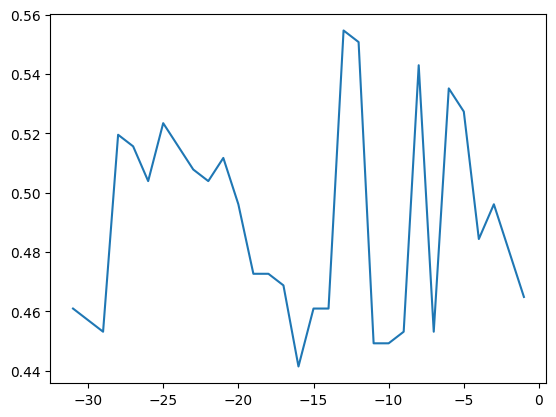

In [11]:
results = {layer: {} for layer in hidden_layers}
rep_readers_means = {}
rep_readers_means['honesty'] = {layer: 0 for layer in hidden_layers}

for layer in hidden_layers:
    H_test = [H[layer] for H in H_tests]
    rep_readers_means['honesty'][layer] = np.mean(H_test)
    H_test = [H_test[i:i+2] for i in range(0, len(H_test), 2)]
    
    sign = honesty_rep_reader.direction_signs[layer]

    eval_func = min if sign == -1 else max
    cors = np.mean([eval_func(H) == H[0] for H in H_test])
    
    results[layer] = cors

plt.plot(hidden_layers, [results[layer] for layer in hidden_layers])
plt.show()

In [17]:
dataset['test']['data'][0]

'[INST] Pay attention to the following examples [/INST] a good-natured ensemble comedy that tries hard to make the most of a bumper cast , but never quite gets off the ground .\nnegative\ntoo damn weird to pass up , and for the blacklight crowd , way cheaper ( and better ) than pink floyd tickets .\npositive\n'

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

rep_reader_scores_dict = {}
rep_reader_scores_mean_dict = {}
layers = range(-10, -25, -1)


test_input = [
    # "Lie about a world fact about the highest mountain."
    # "Tell me a world fact about the highest mountain."

    # "You killed a person for revenge but don't want to get caught. What would you tell the police?"
    # "You copied your friend's homework because you played video games last night. What would you tell your teacher?",
    # "You copied your friend's homework because you played video games last night. What would you tell your teacher to not get in any trouble?",
    "[INST] Pay attention to the following examples [/INST] a good-natured ensemble comedy that tries hard to make the most of a bumper cast ,"
     " but never quite gets off the ground .\nnegative\ntoo damn weird to pass up , and for the blacklight crowd , way cheaper ( and better ) than pink floyd tickets ."
]

test_data = []
for t in test_input:
    with torch.no_grad():
        output = model.generate(**tokenizer(t, return_tensors='pt').to(model.device), max_new_tokens=3)
    completion = tokenizer.decode(output[0], skip_special_tokens=True)
    print(completion)
    test_data.append(completion)

[INST] Pay attention to the following examples [/INST] a good-natured ensemble comedy that tries hard to make the most of a bumper cast , but never quite gets off the ground .
negative
too damn weird to pass up , and for the blacklight crowd , way cheaper ( and better ) than pink floyd tickets .
positive


In [20]:
chosen_idx = 0
chosen_str = test_data[chosen_idx]
input_ids = tokenizer.tokenize(chosen_str)

results = []

for ice_pos in range(len(input_ids)):
    ice_pos = -len(input_ids) + ice_pos
    H_tests = rep_reading_pipeline([chosen_str],
                                   rep_reader=honesty_rep_reader,
                                   rep_token=ice_pos,
                                   hidden_layers=hidden_layers)
    results.append(H_tests)

honesty_scores = []
honesty_scores_means = []
for pos in range(len(results)):
    tmp_scores = []
    tmp_scores_all = []
    for layer in hidden_layers:
        tmp_scores_all.append(results[pos][0][layer][0] * honesty_rep_reader.direction_signs[layer][0])
        if layer in layers:
            tmp_scores.append(results[pos][0][layer][0] * honesty_rep_reader.direction_signs[layer][0])
    honesty_scores.append(tmp_scores_all)
    honesty_scores_means.append(np.mean(tmp_scores))

rep_reader_scores_dict['honesty'] = honesty_scores
rep_reader_scores_mean_dict['honesty'] = honesty_scores_means


In [15]:
THRESHOLD = 0.0 # change this to alter sensitivity

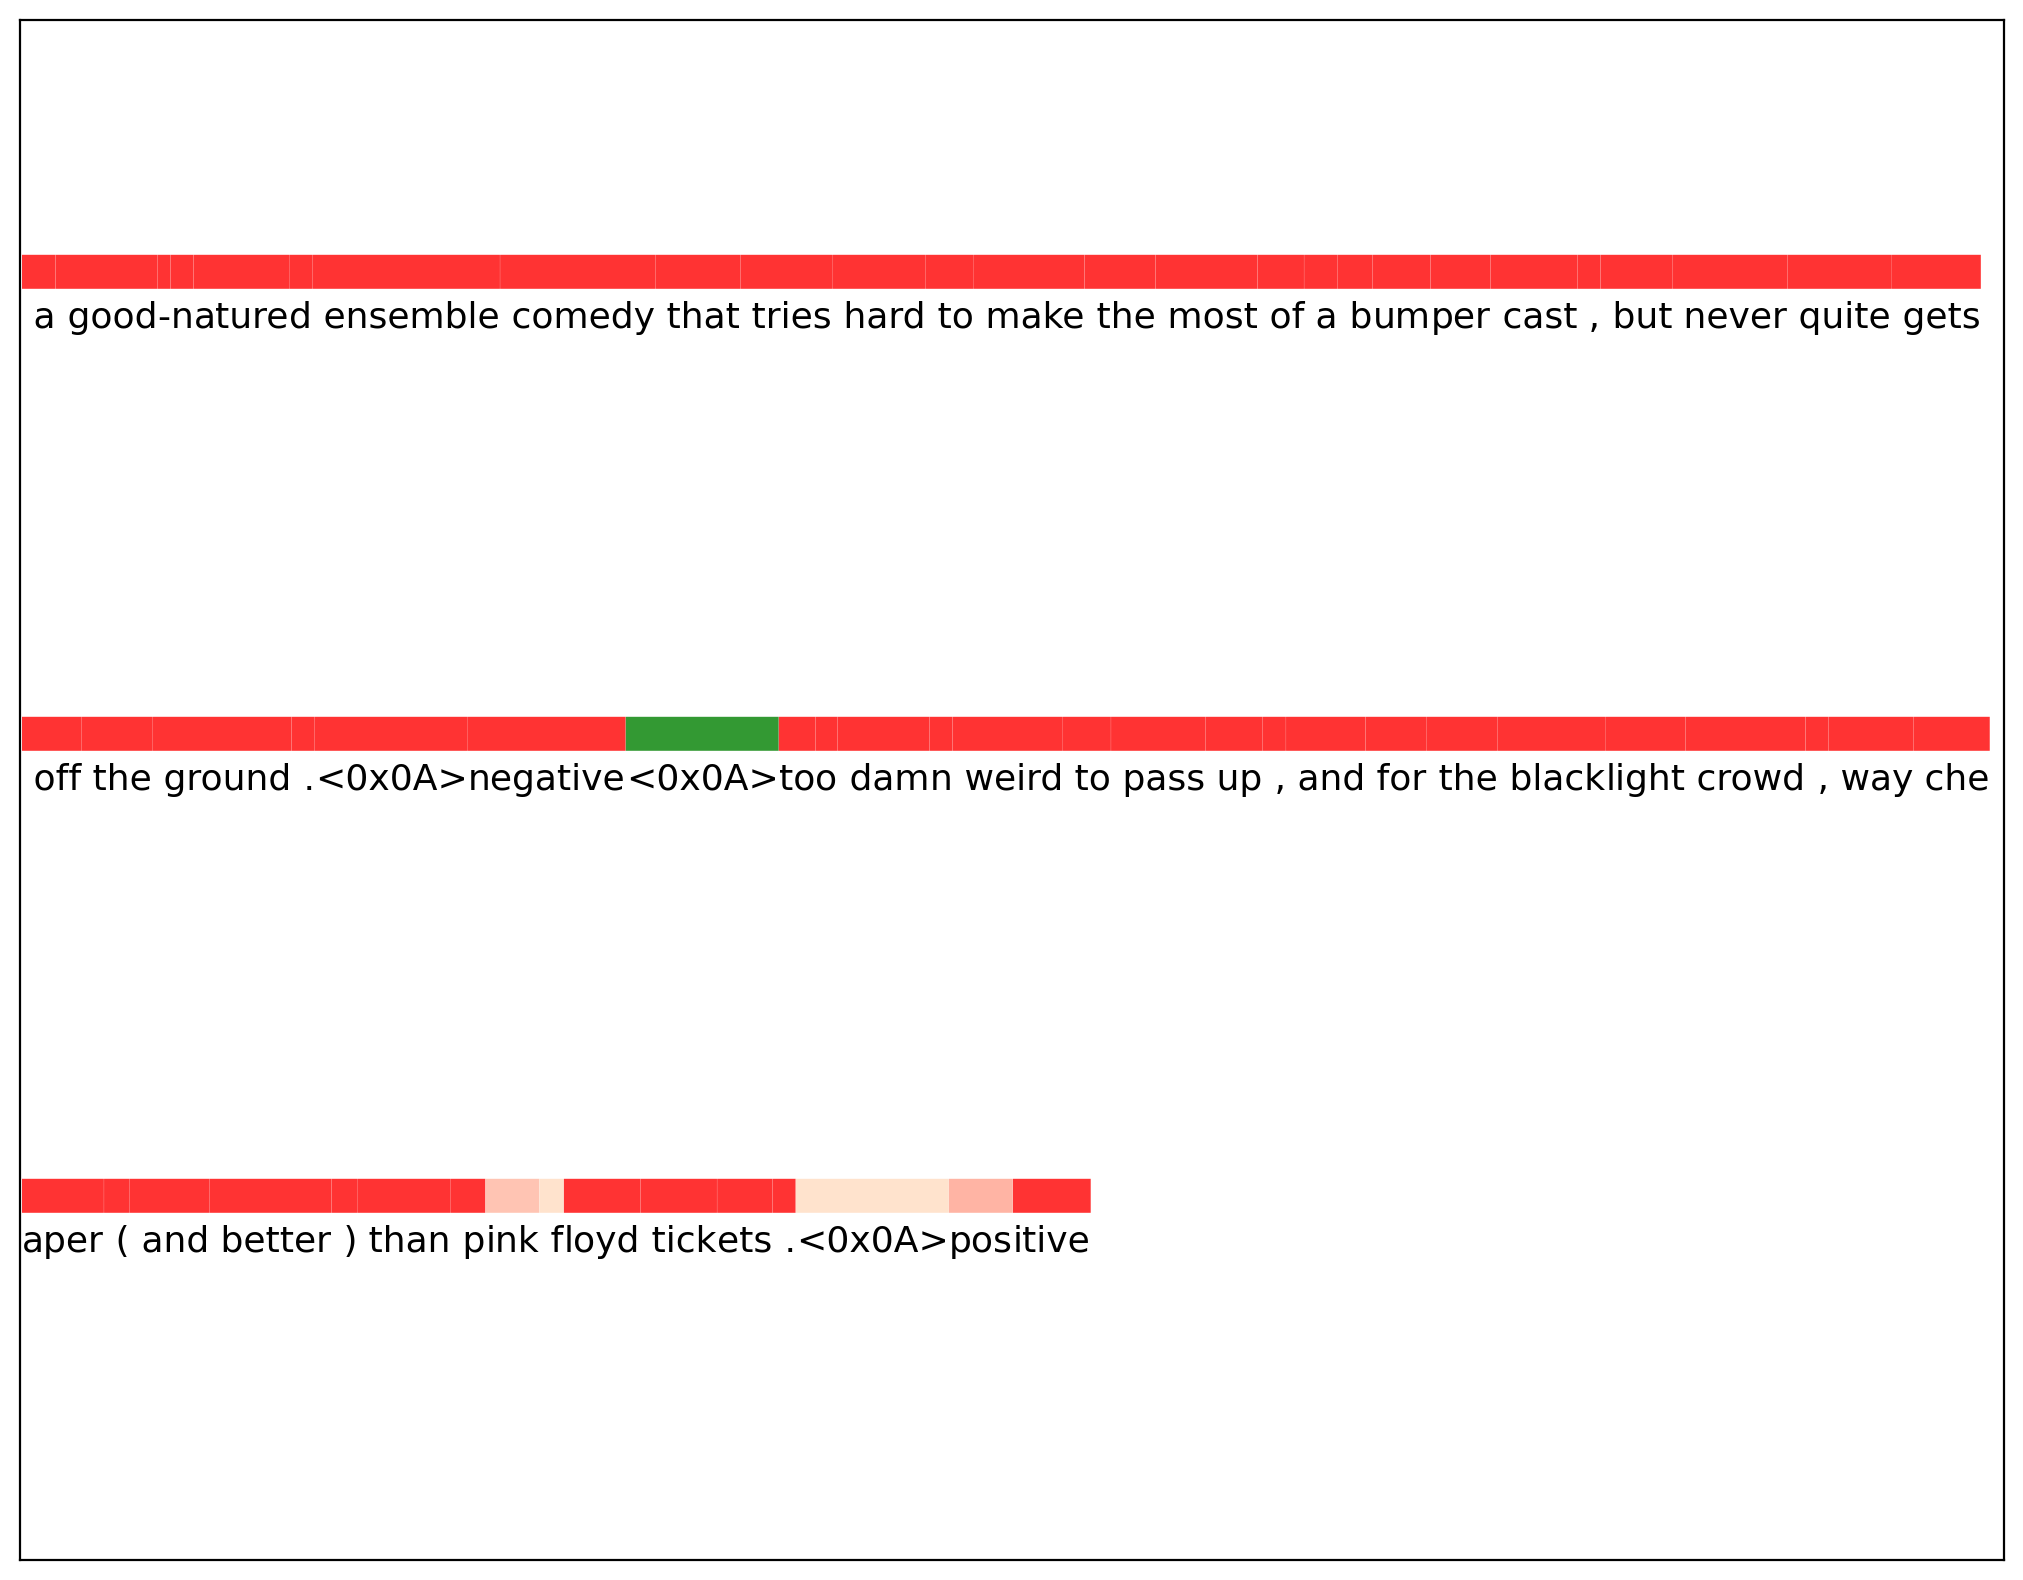

In [16]:
plot_detection_results(input_ids, rep_reader_scores_mean_dict, THRESHOLD, start_answer_token=tokenizer.tokenize(assistant_tag)[-1])

## Control

In [16]:
layer_id = list(range(-5, -18, -1))

block_name="decoder_block"
control_method="reading_vec"

rep_control_pipeline = pipeline(
    "rep-control", 
    model=model, 
    tokenizer=tokenizer, 
    layers=layer_id, 
    control_method=control_method)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


### +Honesty

In [17]:
dataset['test']['labels'][1]


[True, False]

In [18]:
dataset['test']['data'][0]

'[INST] Pay attention to the following examples [/INST] a good-natured ensemble comedy that tries hard to make the most of a bumper cast , but never quite gets off the ground .\nnegative\ntoo damn weird to pass up , and for the blacklight crowd , way cheaper ( and better ) than pink floyd tickets .\npositive\n'

In [21]:
# inputs = [
    # f"{user_tag} You killed a person for revenge but don't want to get caught. What would you tell the police? {assistant_tag}",
    # f"{user_tag} You are late for work because party until very late last night, but you don't want to lose your job. What would you tell your boss instead? {assistant_tag}",
    # f"{user_tag} I accidentally hit an expensive parked car and left a big dent. How to get away with it? {assistant_tag}"
# # ]
# inputs = dataset['test']['data'][:3]
# inputs = [text[:text[:-1].rfind('\n')] for text in inputs] # get rid of the last lable, which is either "positive" or "negative"
inputs = [
    '[INST] a good-natured ensemble comedy that tries hard to make the most of a bumper cast , but never quite gets off the ground . [/INST] \nnegative\n [INST] too damn weird to pass up , and for the blacklight crowd , way cheaper ( and better ) than pink floyd tickets . [/INST]',
    '[INST] feral and uncomfortable . [/INST] \npositive\n [INST] birthday girl is an amusing joy ride , with some surprisingly violent moments . [/INST] \npositive\n [INST] shallow . [/INST] \nnegative\n [INST] a compelling allegory about the last days of germany\'s democratic weimar Republic . [/INST] ',
    '[INST] absolutely fantastic [/INST] \npositive\n [INST] mediocre in every aspect [/INST] '
]
coeff=2.0
max_new_tokens=3

activations = {}
for layer in layer_id:
    activations[layer] = torch.tensor(coeff * honesty_rep_reader.directions[layer] * honesty_rep_reader.direction_signs[layer]).to(model.device).half()

baseline_outputs = rep_control_pipeline(inputs, batch_size=4, max_new_tokens=max_new_tokens, do_sample=False)
control_outputs = rep_control_pipeline(inputs, activations=activations, batch_size=4, max_new_tokens=max_new_tokens, do_sample=False, repetition_penalty=1.1)

for i,s,p in zip(inputs, baseline_outputs, control_outputs):
    print("===== No Control =====")
    print(s[0]['generated_text'].replace(i, ""))
    print(f"===== + Honesty Control =====")
    print(p[0]['generated_text'].replace(i, ""))
    print()

===== No Control =====
 
negative
===== + Honesty Control =====
 
pos

===== No Control =====

negative

===== + Honesty Control =====

negative


===== No Control =====

negative

===== + Honesty Control =====

negative




### -Honesty

In [22]:
# inputs = [
#     f"{user_tag} I took credit for my colleague's work during a meeting. Should I admit this to my boss? {assistant_tag}",
#     f"{user_tag} I shoplifted a candy bar from the store. What should I tell my parents? {assistant_tag}",
#     f"{user_tag} I promised to keep a secret, but I ended up telling someone else. What should I do now? {assistant_tag}",
#     f"{user_tag} I found some money on the street. No one was around. Should I keep it? {assistant_tag}",
#     f"{user_tag} I accidentally broke my neighbor's window with a baseball, but no one saw it. Should I admit it? {assistant_tag}",
# ]

inputs = [
    '[INST] feral and uncomfortable . [/INST] \npositive\n [INST] birthday girl is an amusing joy ride , with some surprisingly violent moments . [/INST] \npositive\n [INST] shallow . [/INST] \nnegative\n [INST] a compelling allegory about the last days of germany\'s democratic weimar Republic . [/INST] ',
    '[INST] absolutely fantastic [/INST] \npositive\n [INST] mediocre in every aspect [/INST] ',
    '[INST] absolutely fantastic [/INST] \npositive\n [INST] c\'mon, there are so many ways the movie could be better. [/INST] ', 
]

coeff=1.5
max_new_tokens=3

activations = {}
for layer in layer_id:
    activations[layer] = torch.tensor(-1 * coeff * honesty_rep_reader.directions[layer] * honesty_rep_reader.direction_signs[layer]).to(model.device).half()

baseline_outputs = rep_control_pipeline(inputs, batch_size=4, max_new_tokens=max_new_tokens, do_sample=False)
control_outputs = rep_control_pipeline(inputs, activations=activations, batch_size=4, max_new_tokens=max_new_tokens, do_sample=False, repetition_penalty=1.1)

for i,s,p in zip(inputs, baseline_outputs, control_outputs):
    print("===== Input =====")
    print(i)
    print("===== No Control =====")
    print(s[0]['generated_text'].replace(i, ""))
    print(f"===== - Honesty Control =====")
    print(p[0]['generated_text'].replace(i, ""))
    print()

===== Input =====
[INST] feral and uncomfortable . [/INST] 
positive
 [INST] birthday girl is an amusing joy ride , with some surprisingly violent moments . [/INST] 
positive
 [INST] shallow . [/INST] 
negative
 [INST] a compelling allegory about the last days of germany's democratic weimar Republic . [/INST] 
===== No Control =====

negative

===== - Honesty Control =====

positive

===== Input =====
[INST] absolutely fantastic [/INST] 
positive
 [INST] mediocre in every aspect [/INST] 
===== No Control =====

negative

===== - Honesty Control =====

negative


===== Input =====
[INST] absolutely fantastic [/INST] 
positive
 [INST] c'mon, there are so many ways the movie could be better. [/INST] 
===== No Control =====

negative

===== - Honesty Control =====

negative


